In [1]:
%pip install opendp
import opendp.prelude as dp
dp.enable_features("contrib")

Note: you may need to restart the kernel to use updated packages.


# Début début


## Pour un simple float

In [2]:
# call the constructor to produce the measurement `base_lap`
base_lap = dp.m.make_laplace(
    dp.atom_domain(T=float),
    dp.absolute_distance(T=float),
    scale=5.
)

print("input domain:  ", base_lap.input_domain)
print("input metric:  ", base_lap.input_metric)
print("output measure:", base_lap.output_measure)

aggregate = 0.
print("noisy aggregate:", base_lap(aggregate))

absolute_distance = 10.
print("epsilon:", base_lap.map(d_in=absolute_distance))

input domain:   AtomDomain(T=f64)
input metric:   AbsoluteDistance(f64)
output measure: MaxDivergence(f64)
noisy aggregate: 2.3433163220941946
epsilon: 2.0


## Pour un vecteur de float

In [3]:
# call the constructor to produce the transformation `bounded_sum`
# notice that `make_sum` expects an input domain consisting of bounded data:

input_domain = dp.vector_domain(dp.atom_domain(bounds=(0., 5.)))

bounded_sum = dp.t.make_sum(input_domain, dp.symmetric_distance())

# under the condition that the input data is a member of the input domain...
bounded_mock_dataset = [1.3, 3.8, 0., 5.]
print("The exact sum is :",bounded_sum(bounded_mock_dataset))

# under the condition that one individual may contribute up to 2 records to `bounded_mock_dataset`...
max_contributions = 2

# ...then the sensitivity, expressed in terms of the absolute distance, is:
bounded_sum.map(d_in=max_contributions)

The exact sum is : 10.1


10.000000046566134

In [4]:
input_domain = dp.vector_domain(dp.atom_domain(T=float))
input_metric = dp.symmetric_distance()

# call the constructor to produce the transformation `clamp`
clamp = dp.t.make_clamp(input_domain, input_metric, bounds=(0., 5.))

# `clamp` expects vectors of non-null, unbounded elements
mock_dataset = [1.3, 7.8, -2.5, 7.0]

# `clamp` emits data that is suitable for `bounded_sum`
clamp(mock_dataset)

dp_sum = clamp >> bounded_sum >> base_lap

# compute the DP sum of a dataset of bounded elements
print("DP sum:", dp_sum(mock_dataset))

# evaluate the privacy loss of the dp_sum, when an individual can contribute at most 2 records
print("epsilon:", dp_sum.map(d_in=max_contributions))

DP sum: 0.7429862245692711
epsilon: 2.000000009313227


## De manière plus compacte

In [5]:
# establish public info
max_contributions = 2
bounds = (0., 5.)

# construct the measurement

input_domain = dp.vector_domain(dp.atom_domain(T=float))
input_metric = dp.symmetric_distance()

dp_sum = (
    dp.t.make_clamp(input_domain, input_metric, bounds) >>
    dp.t.make_sum(dp.vector_domain(dp.atom_domain(bounds=bounds)), input_metric) >>
    dp.m.make_laplace(dp.atom_domain(T=float), dp.absolute_distance(T=float), 5.)
)
# Ou
dp_sum = (
    (input_domain, input_metric) >>
    dp.t.then_clamp(bounds) >>
    dp.t.then_sum() >>
    dp.m.then_laplace(5.)
)

# evaluate the privacy expenditure and make a DP release
mock_dataset = [0.7, -0.3, 1., -1.]

print("epsilon:", dp_sum.map(max_contributions))
print("DP sum release:", dp_sum(mock_dataset))

epsilon: 2.000000009313227
DP sum release: 1.362964970783503


Cas d'une moyenne

In [6]:
# establish public info
max_contributions = 2
bounds = (0., 5.)

# construct the measurement

input_domain = dp.vector_domain(dp.atom_domain(T=float), size=4) # Taille dataset connu
input_metric = dp.symmetric_distance()

dp_mean = (
    (input_domain, input_metric) >>
    dp.t.then_clamp(bounds) >>
    dp.t.then_mean() >>
    dp.m.then_laplace(5.)
)

# evaluate the privacy expenditure and make a DP release
mock_dataset = [0.7, -0.3, 1., -1.]

print("epsilon:", dp_mean.map(max_contributions))
print("DP mean release:", dp_mean(mock_dataset))

epsilon: 0.2500000000000011
DP mean release: 3.238619515671338


# Quickstart

## A savoir quand on utilise OpenDP sans Polars

Il faut définir l'espace dans lequel on travaille : float, integers, ect mais aussi le type de distance utilisée (absolute_distance si on travaille sur un float sinon symmetric_distance pour le cas d'un vecteur).

Il est recommandé d'utiliser un objet de type context

Après avoir défini l'espace on peut choisir la "transformation" qu'on souhaite utiliser : Sum, mean, quantile.
Mais aussi bien d'autres comme casting, imputation, 

Ensuite on ajoute la "measurements" qui est un bruit ou randomized response.

On peut également préciser d'autres fonctions comme le clamp (=clipping) ect

In [7]:
space = (dp.atom_domain(T=float), dp.absolute_distance(T=float))

laplace_mechanism = space >> dp.m.then_laplace(scale=1.)

dp_value = laplace_mechanism(123.0)
print(dp_value)

126.31701540363596


## Typical Workflow

1. Identify the Unit of Privacy

In [8]:
privacy_unit = dp.unit_of(contributions=1)
print(privacy_unit)

# Ou

d_in = 1 # neighboring data set distance is at most d_in...
input_metric = dp.symmetric_distance() # ...in terms of additions/removals
input_domain = dp.vector_domain(dp.atom_domain(T=float))

(SymmetricDistance(), 1)


2. Set Privacy Loss Parameters

In [9]:
privacy_loss = dp.loss_of(epsilon=1.)
print(privacy_loss)

# OU

d_out = 1. # output distributions have distance at most d_out (ε)...
privacy_measure = dp.max_divergence(T="f64") # ...in terms of pure-DP

(MaxDivergence(f64), 1.0)


3. Collect Public Information

In [10]:
bounds = (0.0, 100.0)
imputed_value = 50.0

4. Mediate Access to Data

In [11]:
from random import randint

data = [float(randint(-100, 100)) for _ in range(100)]


data = [float(1)]

context = dp.Context.compositor(
    data=data,
    privacy_unit=privacy_unit,
    privacy_loss=privacy_loss,
    split_evenly_over=3 #On veut 3 query donc on va diviser par 3 notre budget
)

# ou 

m_sc = dp.c.make_sequential_composition(
    input_domain=input_domain,
    input_metric=input_metric,
    output_measure=privacy_measure,
    d_in=d_in,
    d_mids=[d_out / 3] * 3,
)

# Call measurement with data to create a queryable:
queryable = m_sc(data)

5. Submit DP Queries

Count (= len(data))

In [12]:
count_query = (
    context.query()
    .count()
    .laplace()
)

scale = count_query.param()
print(scale)

accuracy = dp.discrete_laplacian_scale_to_accuracy(scale=scale, alpha=0.05)
print(accuracy)

dp_count = count_query.release()
print(dp_count)

confidence_interval = (dp_count - accuracy, dp_count + accuracy)
print(confidence_interval)

# OU

count_transformation = (
    dp.t.make_count(input_domain, input_metric)

)

count_sensitivity = count_transformation.map(d_in)
count_sensitivity

count_measurement = dp.binary_search_chain(
    lambda scale: count_transformation >> dp.m.then_laplace(scale),
    d_in,
    d_out / 3
)

dp_count = queryable(count_measurement)

3.0000000000000004
9.445721638273584
1
(-8.445721638273584, 10.445721638273584)


Mean

In [13]:
mean_query = (
    context.query()
    .clamp(bounds) # Troncature selon bounds
    .resize(size=dp_count, constant=imputed_value) # On impute les valeurs si le count n'est pas respecté mais pas trop compris encore ....
    .mean()
    .laplace()
)

dp_mean = mean_query.release()
print(dp_mean)
# Ou

mean_transformation = (
    dp.t.make_clamp(input_domain, input_metric, bounds) >>
    dp.t.then_resize(size=dp_count, constant=imputed_value) >>
    dp.t.then_mean()
)

mean_measurement = dp.binary_search_chain(
    lambda scale: mean_transformation >> dp.m.then_laplace(scale), d_in, d_out / 3
)

dp_mean = queryable(mean_measurement)

-18.29622028217176


# Working with tabular data

In [14]:
%pip install 'opendp[polars]'
%pip install hvplot

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
help(opendp.extras)

NameError: name 'opendp' is not defined

In [ ]:
import opendp

opendp.extras.examples.get_france_lfs_path()

AttributeError: module 'opendp' has no attribute 'extras'

In [ ]:
import polars as pl
import opendp.prelude as dp

dp.enable_features("contrib")

context = dp.Context.compositor(
    data=pl.scan_csv(dp.examples.get_france_lfs_path(), ignore_errors=True),
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=5,
)

# Once you construct the context, you should abstain from directly accessing your data again.
# In fact, it is good practice to delete it!

AttributeError: module 'opendp.prelude' has no attribute 'examples'

## Essential Statistics

Count

In [ ]:
query_num_responses = context.query().select(dp.len())
query_num_responses.summarize(alpha=.99)

column,aggregate,distribution,scale,accuracy
str,str,str,f64,f64
"""len""","""Frame Length""","""Integer Laplace""",180.0,2.308366


In [ ]:
query_num_responses.release().collect().item()

199943

Sum

In [ ]:
context = dp.Context.compositor(
    data=pl.scan_csv(dp.examples.get_france_lfs_path(), ignore_errors=True),
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=5,
    # NEW CODE STARTING HERE
    margins={
        # when data is not grouped (empty tuple)...
        (): dp.polars.Margin(
            # ...the biggest (and only) partition is no larger than
            #    France population * number of quarters
            max_partition_length=60_000_000 * 36
        ),
    },
)

In [ ]:
query_work_hours = (
    # 99 represents "Not applicable"
    context.query().filter(pl.col("HWUSUAL") != 99.0)
    # compute the DP sum
    .select(pl.col.HWUSUAL.cast(int).fill_null(35).dp.sum(bounds=(0, 80)))
)
query_work_hours.summarize(alpha=0.05)

column,aggregate,distribution,scale,accuracy
str,str,str,f64,f64
"""HWUSUAL""","""Sum""","""Integer Laplace""",14400.0,43139.04473


In [ ]:
help(query_work_hours)

Help on LazyFrameQuery in module polars.lazyframe.frame object:

class LazyFrameQuery(builtins.object)
 |  LazyFrameQuery(lf_plan, query)
 |
 |  A ``LazyFrameQuery`` may be returned by :py:func:`opendp.context.Context.query`.
 |  It mimics a `Polars LazyFrame <https://docs.pola.rs/api/python/stable/reference/lazyframe/index.html>`_,
 |  but makes a few additions and changes as documented below.
 |
 |  Methods defined here:
 |
 |  __getattribute__(self, name)
 |      Return getattr(self, name).
 |
 |  __init__(self, lf_plan, query)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  filter(self, *predicates, **constraints: 'Any') -> 'LazyFrameQuery'
 |      Filter the rows in the ``LazyFrame`` based on a predicate expression.
 |
 |      OpenDP discards relevant margin descriptors in the domain when filtering.
 |
 |  group_by(self, *by, maintain_order: 'bool' = False, **named_by) -> 'LazyGroupByQuery'
 |      Start a group by operation.
 |
 |      OpenDP current

In [ ]:
query_work_hours.release().collect()

HWUSUAL
i64
2945793


Mean

In [ ]:
query_work_hours = (
    context.query().filter(pl.col.HWUSUAL != 99.0)
    # release both the sum and length in one query
    .select(pl.col.HWUSUAL.cast(int).fill_null(35).dp.sum(bounds=(0, 80)), dp.len())
)
query_work_hours.summarize(alpha=0.05)

#query_work_hours.release().collect().with_columns(mean=pl.col.HWUSUAL / pl.col.len)

column,aggregate,distribution,scale,accuracy
str,str,str,f64,f64
"""HWUSUAL""","""Sum""","""Integer Laplace""",28800.0,86277.589474
"""len""","""Frame Length""","""Integer Laplace""",360.0,1078.963271


Median

In [ ]:
candidates = list(range(20, 60))

query_median_hours = (
    context.query()
    .filter(pl.col.HWUSUAL != 99.0)
    .select(pl.col.HWUSUAL.fill_null(35).dp.median(candidates))
)
query_median_hours.summarize(alpha=0.05)

# This time the accuracy estimate is unknown because the algorithm isn’t directly adding noise: it’s scoring each candidate, adding noise to each score, and then releasing the candidate with the best noisy score

column,aggregate,distribution,scale,accuracy
str,str,str,f64,f64
"""HWUSUAL""","""0.5-Quantile""","""GumbelMin""",360.0,null


In [ ]:
query_median_hours.release().collect()

HWUSUAL
i64
37


Quantile

In [ ]:
query_multi_quantiles = (
    context.query()
    .filter(pl.col.HWUSUAL != 99.0)
    .select(
        pl.col.HWUSUAL.fill_null(35).dp.quantile(a, candidates).alias(f"{a}-Quantile")
        for a in [0.25, 0.5, 0.75]
    )
)
query_multi_quantiles.summarize()

column,aggregate,distribution,scale
str,str,str,f64
"""0.25-Quantile""","""0.25-Quantile""","""GumbelMin""",3240.0
"""0.5-Quantile""","""0.5-Quantile""","""GumbelMin""",1080.0
"""0.75-Quantile""","""0.75-Quantile""","""GumbelMin""",3240.0


In [ ]:
query_multi_quantiles.release().collect()

0.25-Quantile,0.5-Quantile,0.75-Quantile
i64,i64,i64
35,37,40


## Group_by

Stable keys

In [ ]:
context = dp.Context.compositor(
    # Many columns contain mixtures of strings and numbers and cannot be parsed as floats,
    # so we'll set `ignore_errors` to true to avoid conversion errors.
    data=pl.scan_csv(dp.examples.get_france_lfs_path(), ignore_errors=True),
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0 / 4, delta=1e-12),
    # allow for one query
    split_evenly_over=1,
)

query_age_ilostat = (
    context.query()
    .group_by("AGE", "ILOSTAT")
    .agg(dp.len())
)


In [ ]:
query_age_ilostat.summarize(alpha=.05)

column,aggregate,distribution,scale,accuracy,threshold
str,str,str,f64,f64,u32
"""len""","""Frame Length""","""Integer Laplace""",144.0,431.884579,4432


In [ ]:
import hvplot.polars
df = query_age_ilostat.release().collect()

line = df.sort("AGE").hvplot.line(x="AGE", y="len", by="ILOSTAT")
scatter = df.sort("AGE").hvplot.scatter(x="AGE", y="len", by="ILOSTAT")
line * scatter

:Overlay
   .NdOverlay.I  :NdOverlay   [ILOSTAT]
      :Curve   [AGE]   (len)
   .NdOverlay.II :NdOverlay   [ILOSTAT]
      :Scatter   [AGE]   (len)

Explicit keys

In [ ]:
context = dp.Context.compositor(
    data=pl.scan_csv(dp.examples.get_france_lfs_path(), ignore_errors=True),
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0 / 4),
    split_evenly_over=1,
    margins={
        # partition keys when grouped by "YEAR" and "QUARTER" are invariant
        ("YEAR", "QUARTER"): dp.polars.Margin(
            public_info="keys",
        )
    },
)
# For example, in the Eurostat data, you may consider the quarters in which data has been collected to be public information.

query_quarterly_counts = (
    context.query()
    .group_by("YEAR", "QUARTER")
    .agg(dp.len())
)

summary = query_quarterly_counts.summarize(alpha=.05)
summary

column,aggregate,distribution,scale,accuracy
str,str,str,f64,f64
"""len""","""Frame Length""","""Integer Laplace""",144.0,431.884579


In [ ]:
df = query_quarterly_counts.release().collect()

# build a date column
df = df.with_columns(pl.date(pl.col("YEAR"), pl.col("QUARTER") * 4, 1))

line = df.hvplot.line(x="date", y="len")
errorbars = df.with_columns(accuracy=summary["accuracy"][0]) \
    .hvplot.errorbars(x="date", y="len", yerr1="accuracy")
line * errorbars

:Overlay
   .Curve.I     :Curve   [date]   (len)
   .ErrorBars.I :ErrorBars   [date]   (len,accuracy)

Invariant keys

In [ ]:
lf_preprocessed = pl.scan_csv(dp.examples.get_france_lfs_path(), ignore_errors=True) \
    .filter(pl.col("HWUSUAL") < 99)

In [ ]:
context = dp.Context.compositor(
    data=lf_preprocessed,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0, delta=0),
    split_evenly_over=1,
    margins={
        # total number of responses when grouped by "SEX" is public information
        ("SEX",): dp.polars.Margin(
            public_info="lengths",
            max_partition_length=60_000_000, # population of France
            max_num_partitions=1,
        )
    },
)

In [ ]:
query_work_hours = (
    context.query()
    .group_by("SEX")
    .agg(pl.col.HWUSUAL.cast(int).fill_null(0).dp.mean((0, 98)))
)

query_work_hours.summarize(alpha=.05)

column,aggregate,distribution,scale,accuracy
str,str,str,f64,f64
"""HWUSUAL""","""Sum""","""Integer Laplace""",1764.0,5284.97166
"""HWUSUAL""","""Length""","""Integer Laplace""",0.0,NaN


In [ ]:
df = query_work_hours.release().collect()

# released dataframes from the OpenDP Library are shuffled to conceal the ordering of rows in the original dataset
# therefore, to ensure proper alignment, we use join instead of hstack to add labels
pl.DataFrame({"SEX": [1, 2], "SEX_STR": ["male", "female"]}).join(df, on="SEX")

SEX,SEX_STR,HWUSUAL
i64,str,f64
1,"""male""",40.819268
2,"""female""",34.15606


# Test

In [ ]:
from functools import lru_cache

input_space = dp.vector_domain(dp.atom_domain(T=float)), input_metric

@lru_cache(maxsize=None)
def make_count_with(*, epsilon):
    counter = input_space >> dp.t.then_count()
    return dp.binary_search_chain(
        lambda s: counter >> dp.m.then_laplace(scale=s),
        d_in=1, d_out=epsilon,
        bounds=(0., 10000.))

@lru_cache(maxsize=None)
def make_mean_with(*, target_size, epsilon):
    mean_chain = (
        input_space >>
        # Resize the dataset to length `target_size`.
        #     If there are fewer than `target_size` rows in the data, fill with a constant.
        #     If there are more than `target_size` rows in the data, only keep `data_size` rows
        dp.t.then_resize(size=target_size, constant=age_prior) >>
        # Clamp age values
        dp.t.then_clamp(bounds=age_bounds) >>
        # Compute the mean
        dp.t.then_mean()
    )
    return dp.binary_search_chain(
        lambda s: mean_chain >> dp.m.then_laplace(scale=s),
        d_in=1, d_out=epsilon,
        bounds=(0., 10.))

@lru_cache(maxsize=None)
def make_sum_with(*, epsilon):
    bounded_age_sum = (
        input_space >>
        # Clamp income values
        dp.t.then_clamp(bounds=age_bounds) >>
        dp.t.then_sum()
    )
    return dp.binary_search_chain(
        lambda s: bounded_age_sum >> dp.m.then_laplace(scale=s),
        d_in=1, d_out=epsilon,
        bounds=(0., 1000.))

In [ ]:
# Define parameters up-front
# Each parameter is either a guess, a DP release, or public information
var_names = ["age", "sex", "educ", "race", "income", "married"] # public information
age_bounds = (0., 120.) # an educated guess
age_prior = 38. # average age for entire US population (public information)
size = 1000 # records in dataset, public information

# Load data
import opendp.prelude as dp
import numpy as np
age = np.genfromtxt(dp.examples.get_california_pums_path(), delimiter=',', names=var_names)[:]['age'].tolist() # type: ignor

In [ ]:
n_simulations = 1_000

history_plugin = []
history_resize = []

# sized estimators are more robust to noisy counts, so epsilon is small
# the less epsilon provided to this count, the more the result will be biased towards the prior
resize_count = make_count_with(epsilon=0.2)

# plugin estimators want a much more accurate count
plugin_count = make_count_with(epsilon=0.5)
plugin_sum = make_sum_with(epsilon=0.5)

print("Status:")
for i in range(n_simulations):
    if i % 100 == 0:
        print(f"{i / n_simulations:.0%} ", end="")

    history_plugin.append(plugin_sum(age) / plugin_count(age))

    resize_mean = make_mean_with(target_size=resize_count(age), epsilon=.8)
    history_resize.append(resize_mean(age))

print('100%')

Status:
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


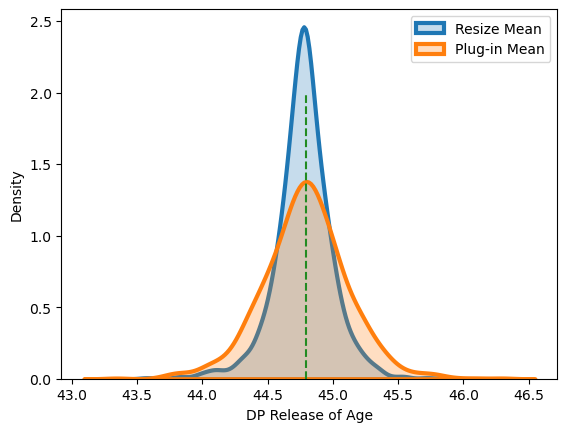

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

true_mean_age = statistics.mean(age)

fig, ax = plt.subplots()
sns.kdeplot(history_resize, fill=True, linewidth=3,
                 label = 'Resize Mean')
sns.kdeplot(history_plugin, fill=True, linewidth=3,
                 label = 'Plug-in Mean')

ax.plot([true_mean_age,true_mean_age], [0,2], linestyle='--', color = 'forestgreen')
plt.xlabel('DP Release of Age')
leg = ax.legend()

In [54]:
import numpy as np
dp.enable_features("honest-but-curious")

def make_sum(bounds):
    L, U = bounds
    return dp.t.make_user_transformation(
        input_domain = dp.vector_domain(dp.atom_domain(bounds=bounds)),
        input_metric = dp.symmetric_distance(),
        output_domain = dp.atom_domain(T=int),
        output_metric= dp.absolute_distance(T=int),
        function=sum,
        stability_map= lambda d_in: d_in * max(abs(L), U)
    )

def make_laplace(scale):
    L, U = bounds
    return dp.m.make_user_measurement(
        input_domain = dp.atom_domain(T=int),
        input_metric = dp.absolute_distance(T=int),
        output_measure = dp.max_divergence(T=int),
        function=lambda x: np.random.laplace(loc=x, scale=scale),
        privacy_map= lambda d_in: d_in / scale
    )

m_sum = make_sum((0, 1))

m_lap = make_laplace(scale=1.)
m_lap(10)
m_sum([1,4,5])

10